# Exploratory Data Analysis

## Libraries

In [44]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

## Data Inspection

In [17]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset contains the following columns:

- **age**: The person’s age in years
- **sex**: The person’s sex (1 = male, 0 = female)
- **cp**: Chest pain type
  - Value 0: Asymptomatic
  - Value 1: Atypical angina
  - Value 2: Non-anginal pain
  - Value 3: Typical angina
- **trestbps**: The person’s resting blood pressure (mm Hg on admission to the hospital)
- **chol**: The person’s cholesterol measurement in mg/dl
- **fbs**: Fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- **restecg**: Resting electrocardiographic results
  - Value 0: Showing probable or definite left ventricular hypertrophy by Estes’ criteria
  - Value 1: Normal
  - Value 2: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- **thalach**: The person’s maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)
- **slope**: The slope of the peak exercise ST segment
  - Value 0: Downsloping
  - Value 1: Flat
  - Value 2: Upsloping
- **ca**: The number of major vessels (0–3)
- **thal**: A blood disorder called thalassemia
  - Value 0: NULL (dropped from the dataset previously)
  - Value 1: Fixed defect (no blood flow in some part of the heart)
  - Value 2: Normal blood flow
  - Value 3: Reversible defect (blood flow observed but not normal)
- **target**: Heart disease (1 = no, 0 = yes)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [23]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [28]:
num_vars = ["age", "trtbps", "chol", "thalachh", "oldpeak"]
cat_vars = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]
target = "output"

## Univariate Analysis

### Numerical Variables

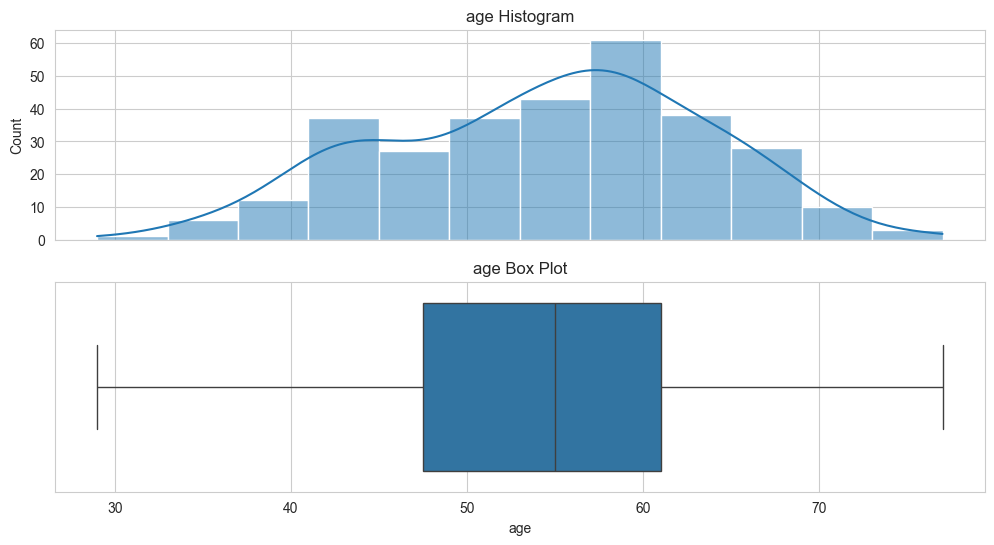

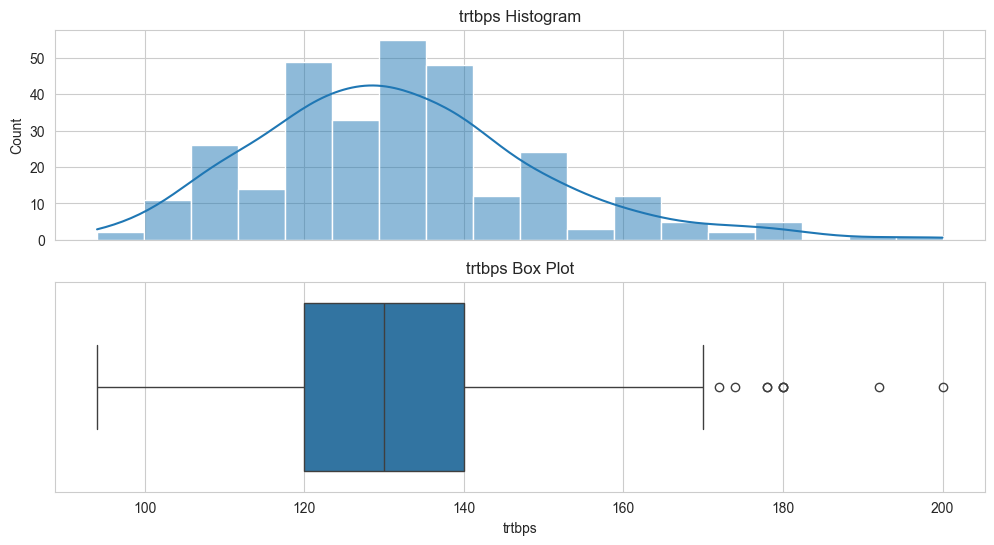

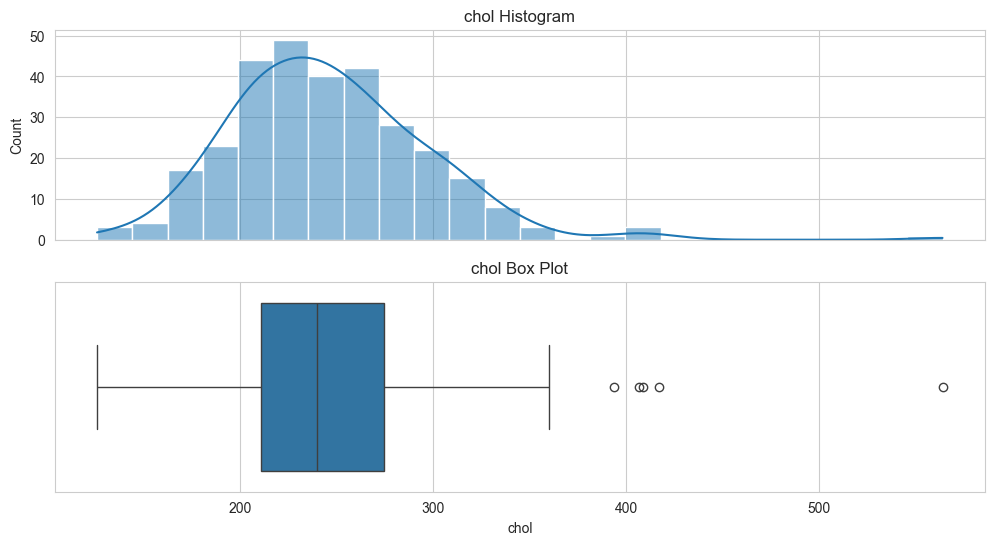

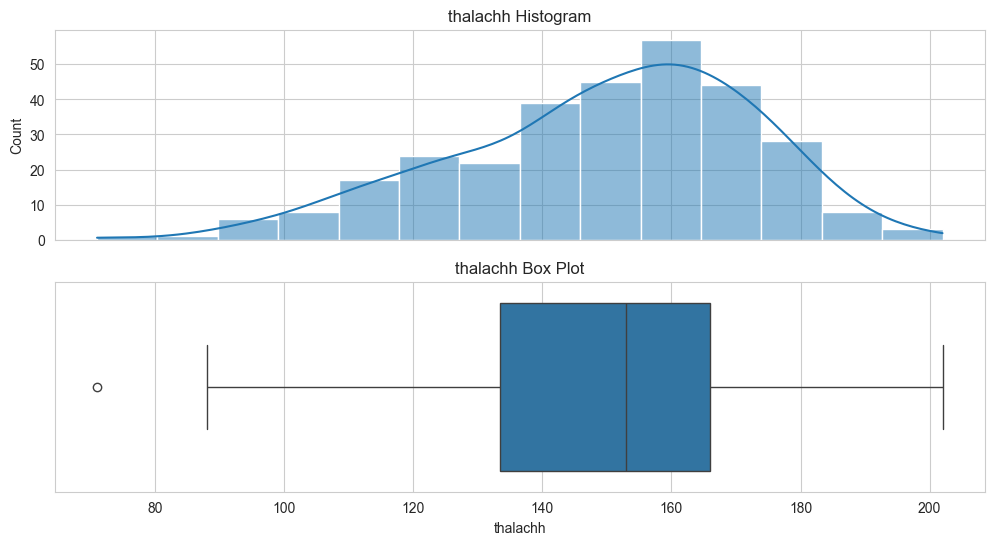

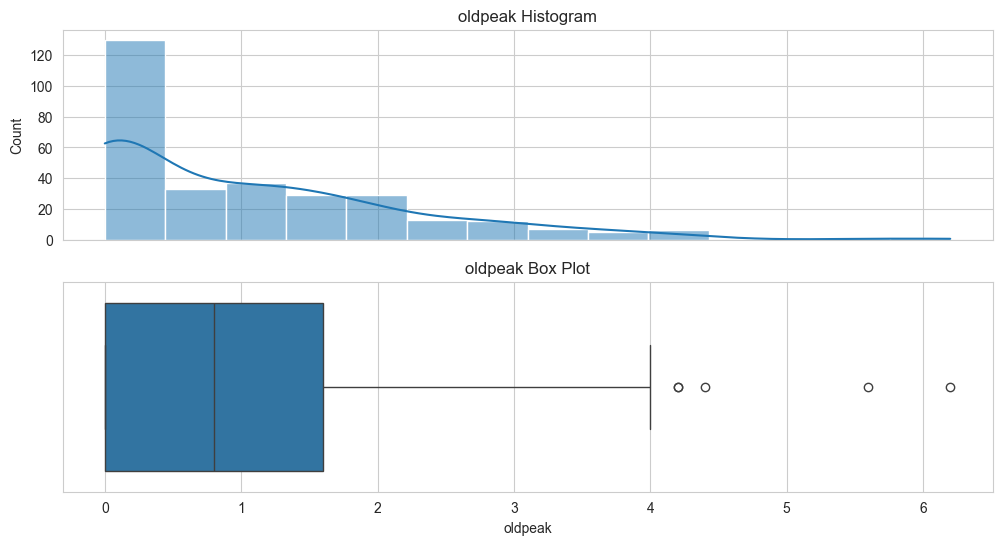

In [52]:
for var in num_vars:
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    sns.histplot(df[var], ax=ax[0], kde=True)
    ax[0].set_title(f"{var} Histogram")
    sns.boxplot(df[var], ax=ax[1], orient="h")
    ax[1].set_title(f"{var} Box Plot")
    plt.show()

### Categorical Variables

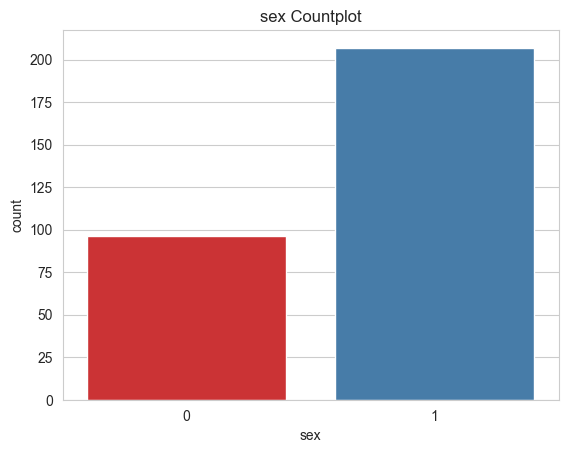

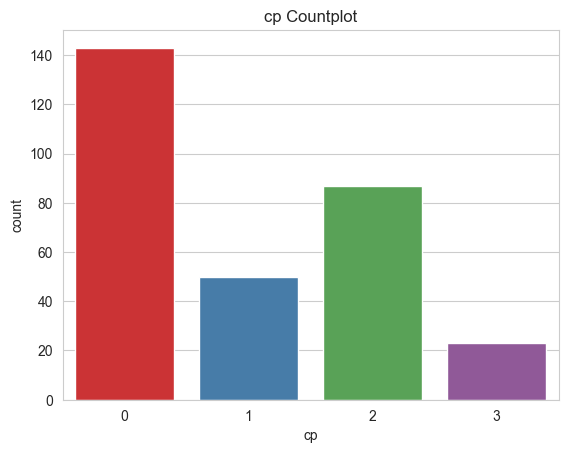

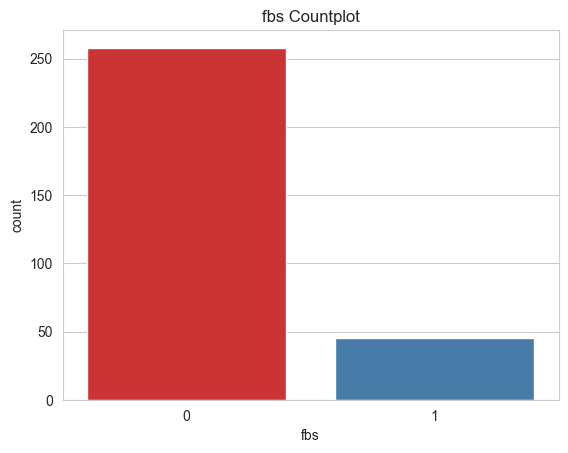

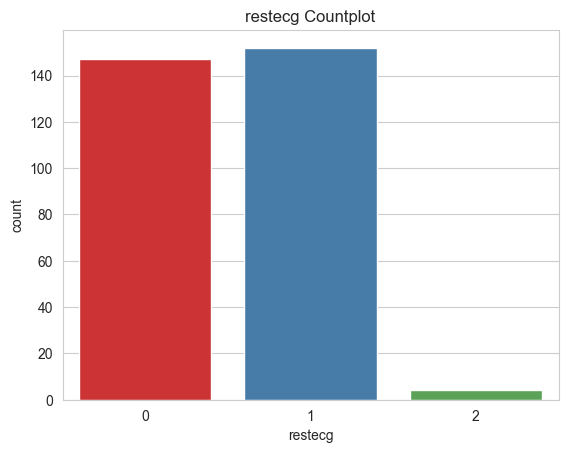

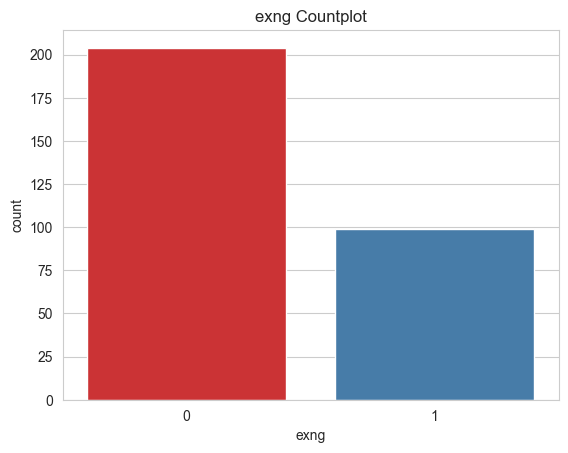

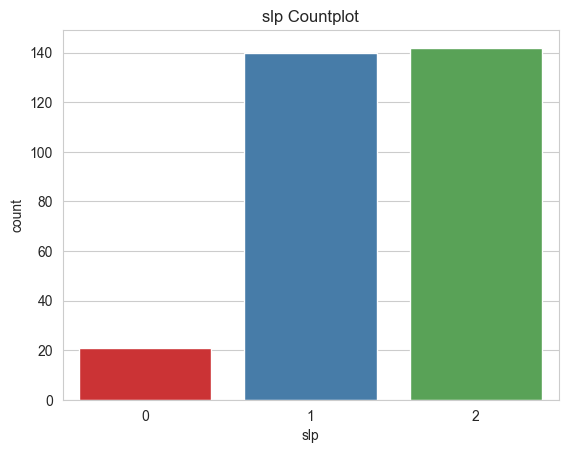

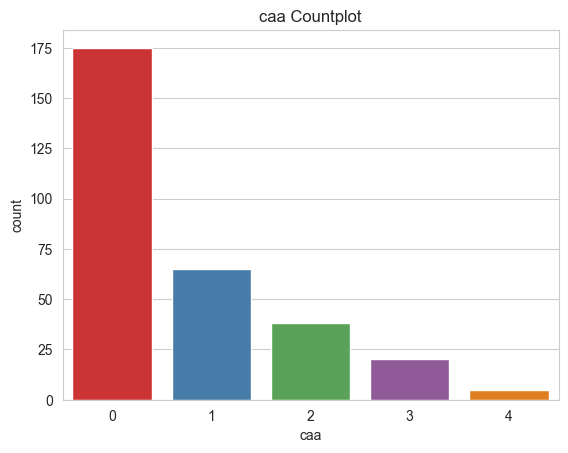

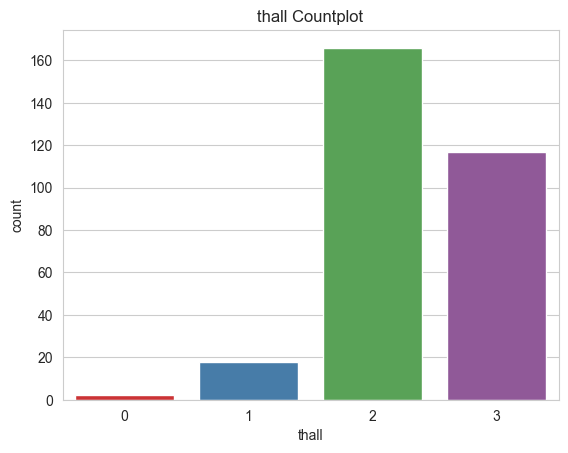

In [55]:
for var in cat_vars:
    sns.countplot(df, x=var, palette="Set1")
    plt.title(f"{var} Countplot")
    plt.show()

### Target

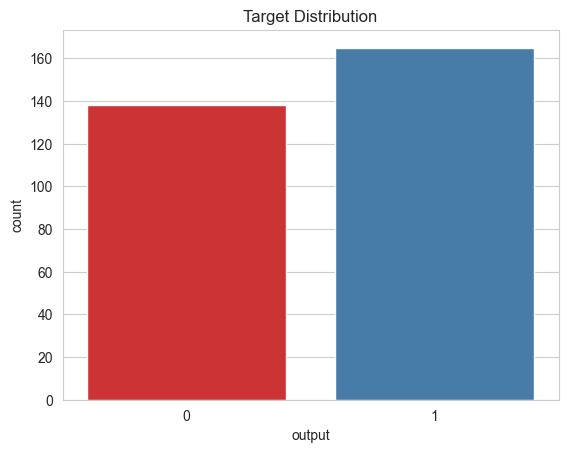

In [56]:
sns.countplot(df, x="output", palette="Set1")
plt.title("Target Distribution")
plt.show()

## Bivariate Analysis

In [68]:
from itertools import combinations, product

### Numerical vs Numerical

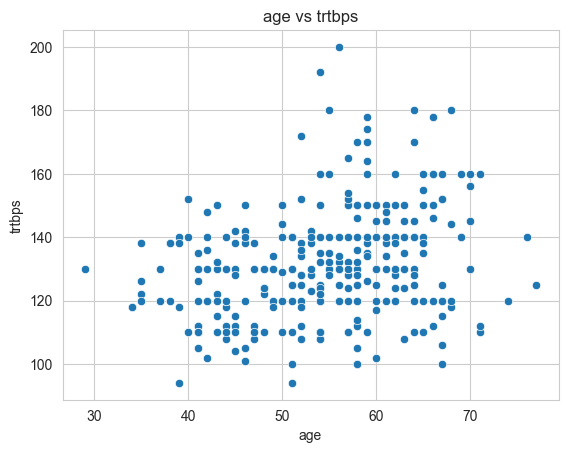

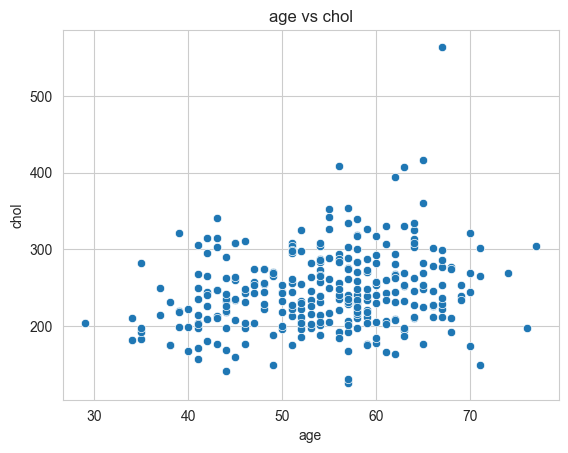

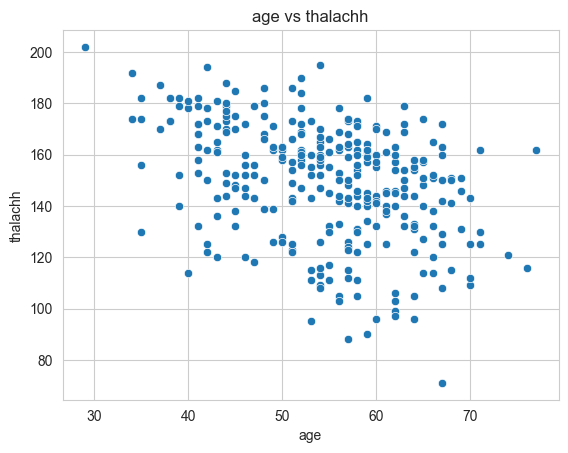

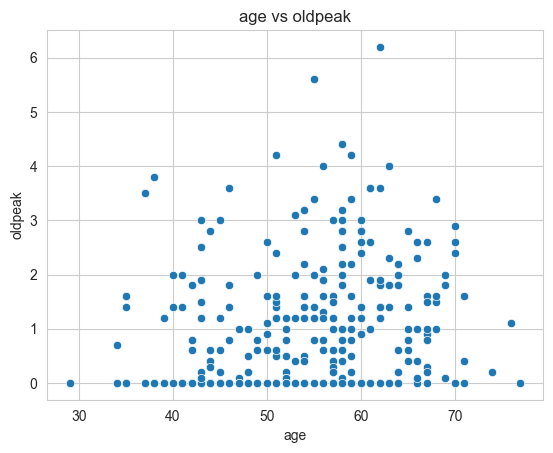

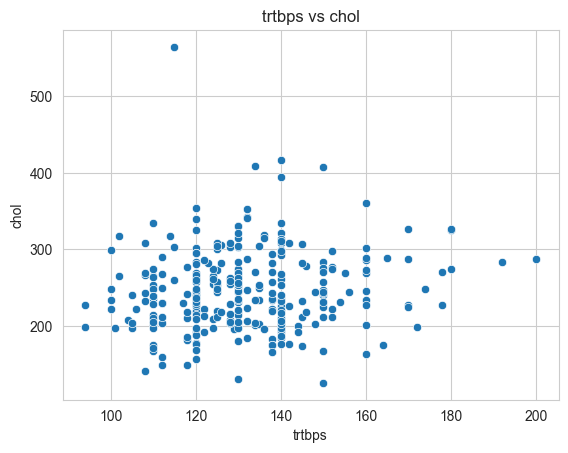

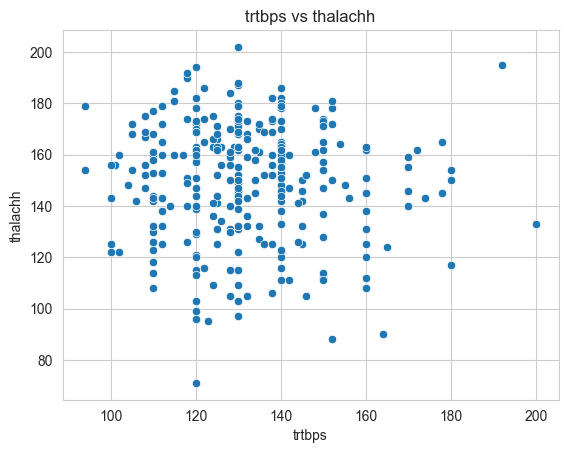

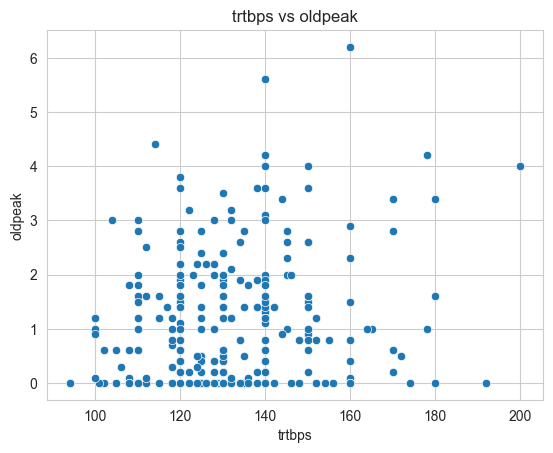

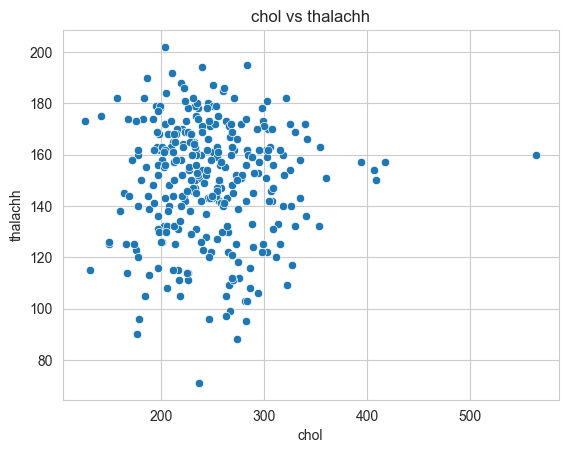

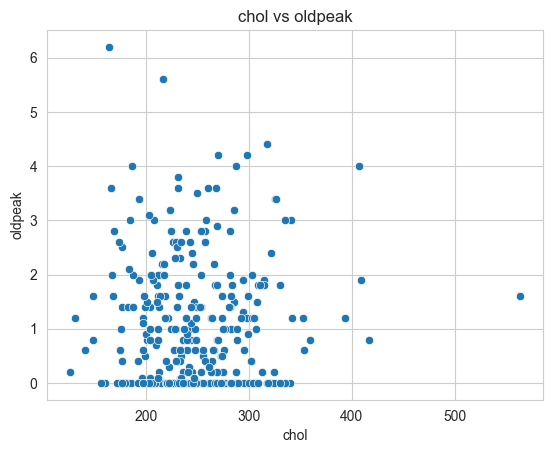

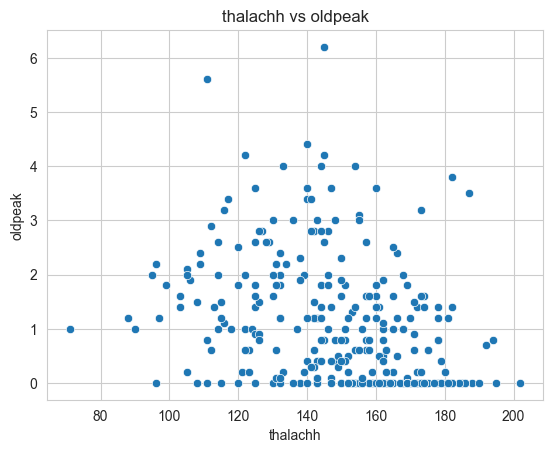

In [66]:
num_var_pairs = list(combinations(num_vars, 2))
for num1, num2 in num_var_pairs:
    sns.scatterplot(df, x=num1, y=num2)
    plt.title(f"{num1} vs {num2}")
    plt.show()

### Numerical vs Categorical

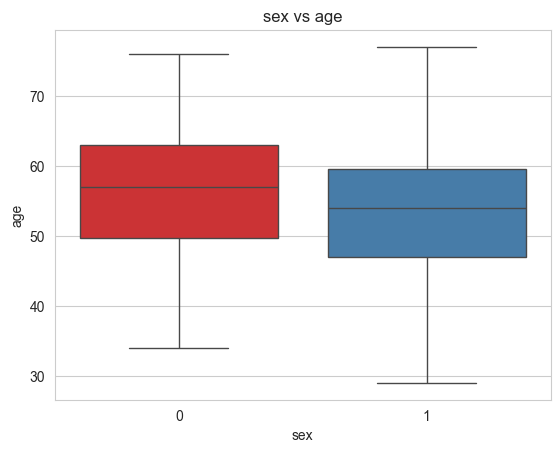

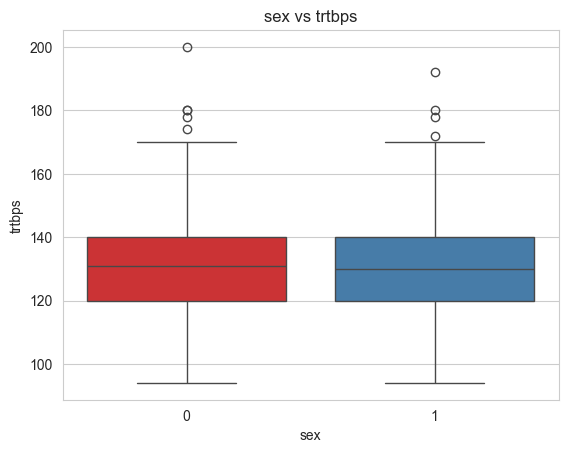

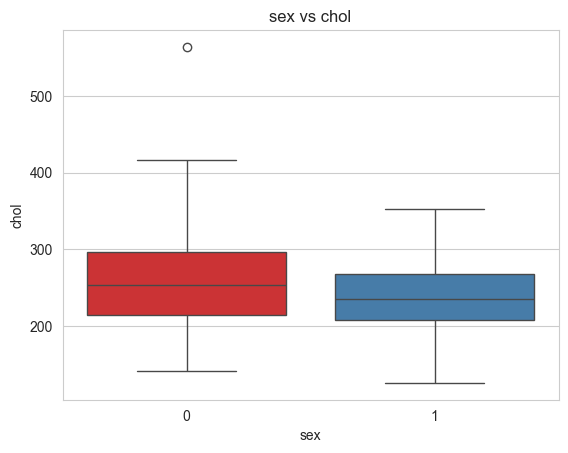

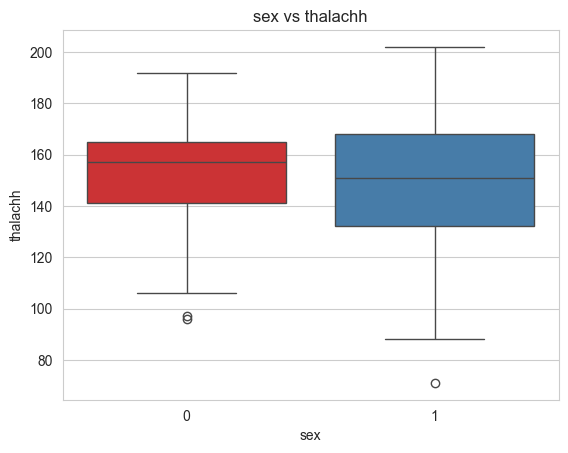

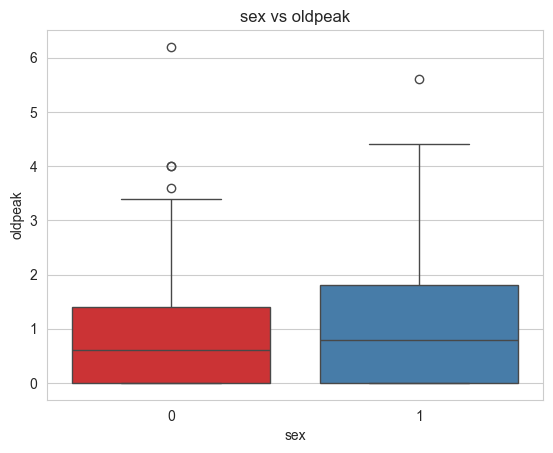

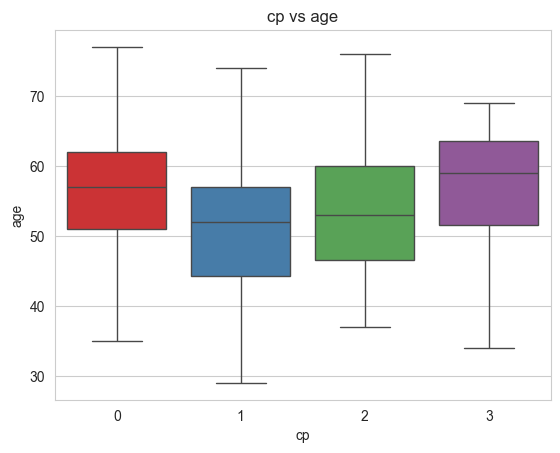

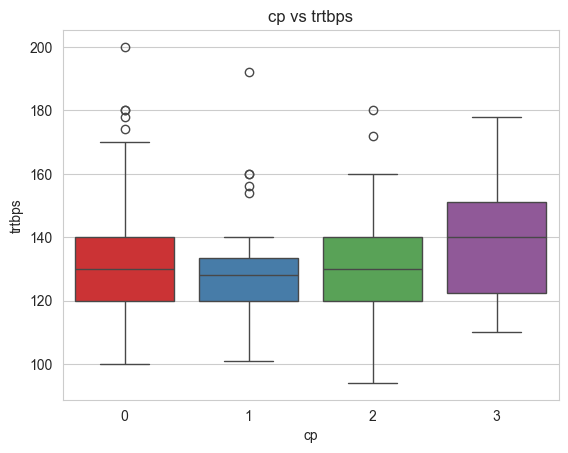

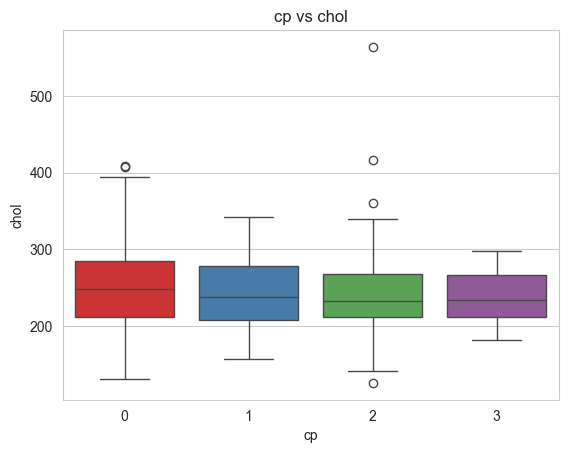

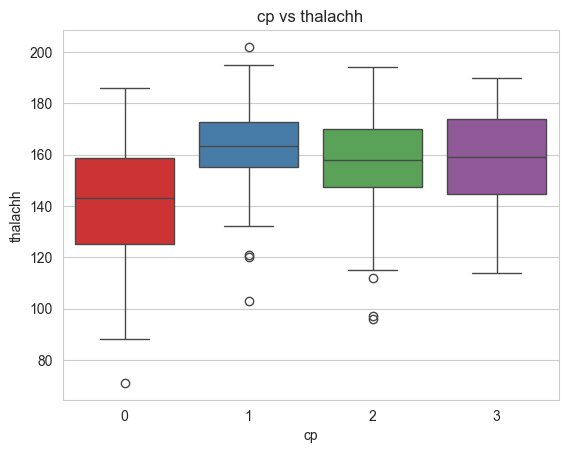

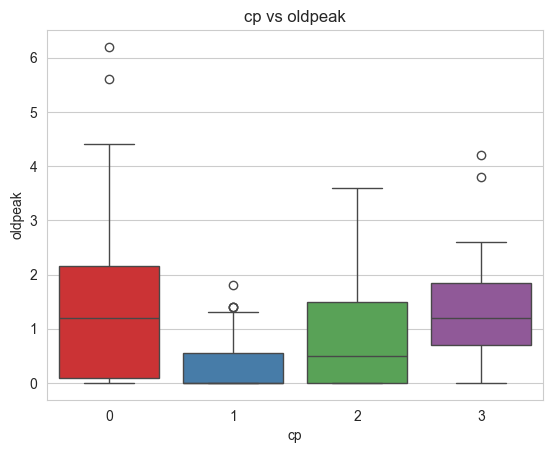

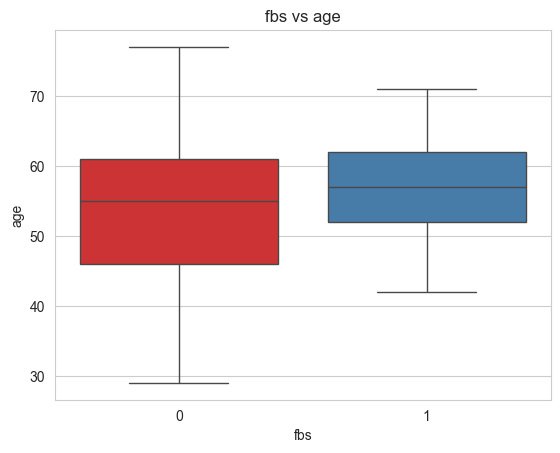

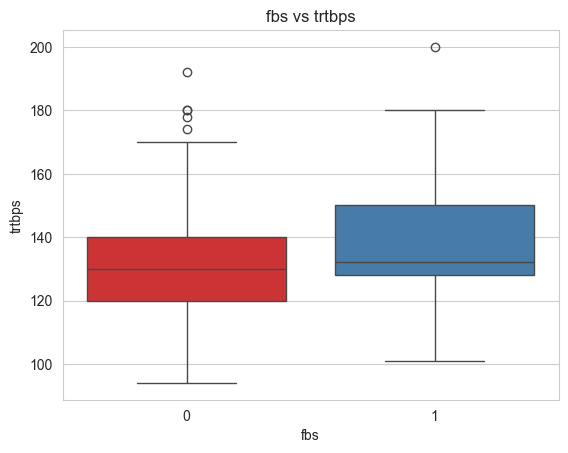

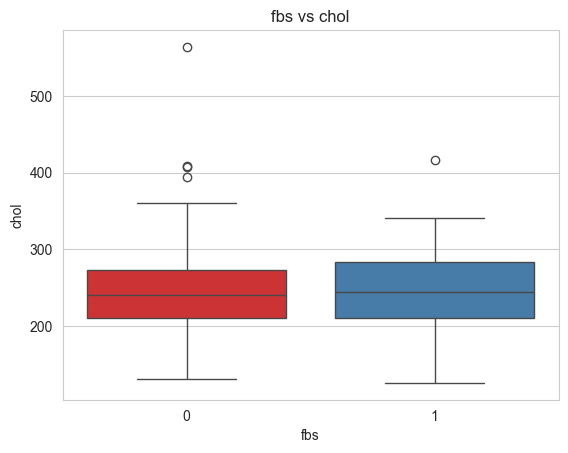

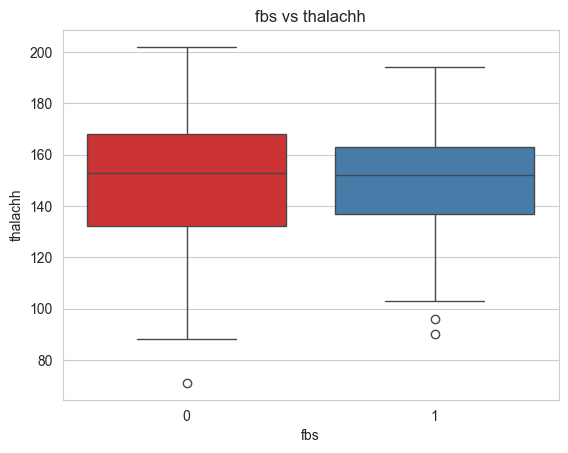

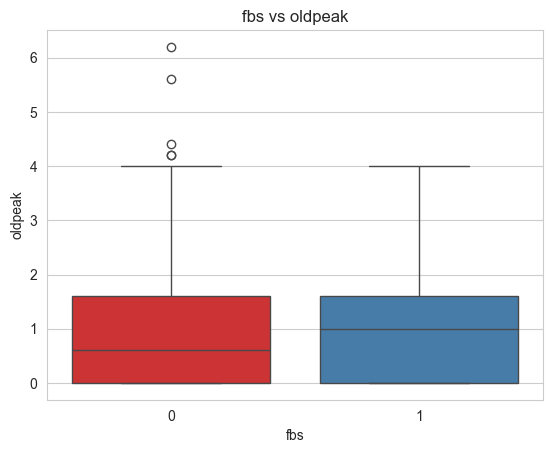

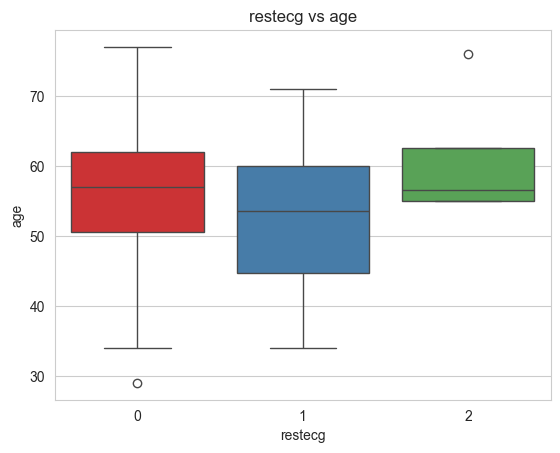

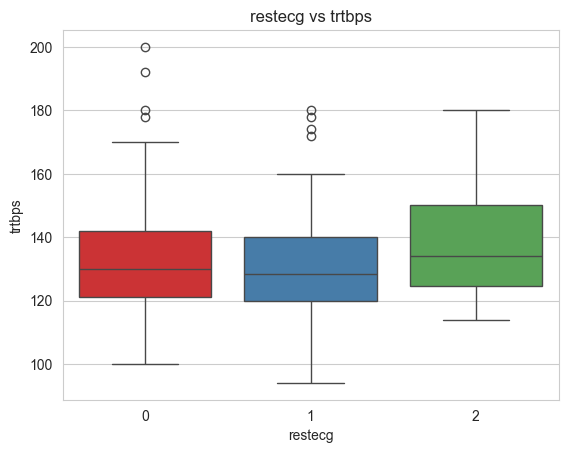

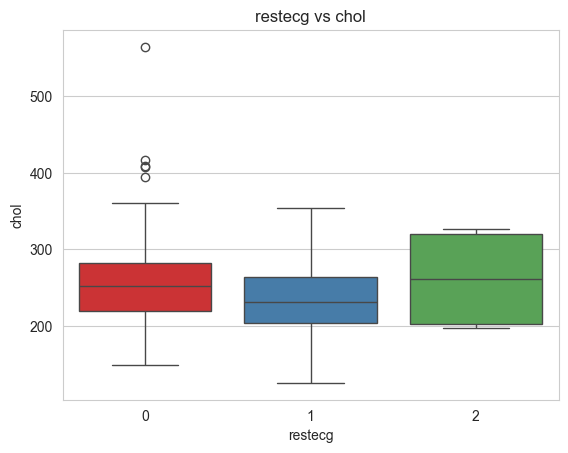

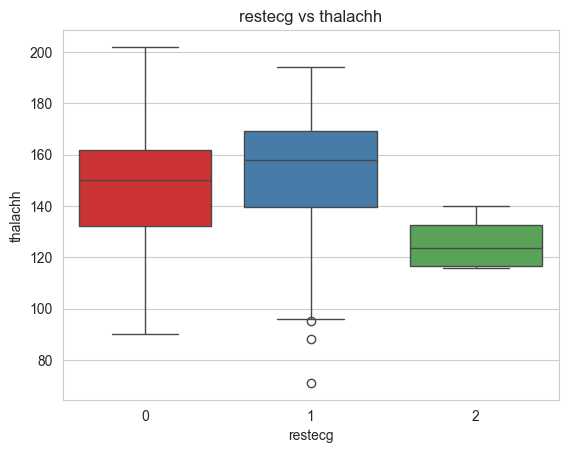

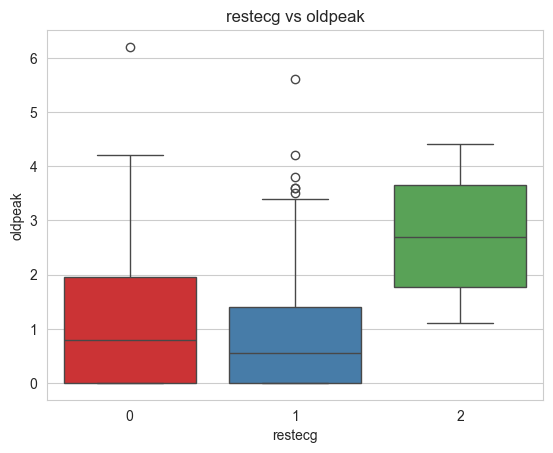

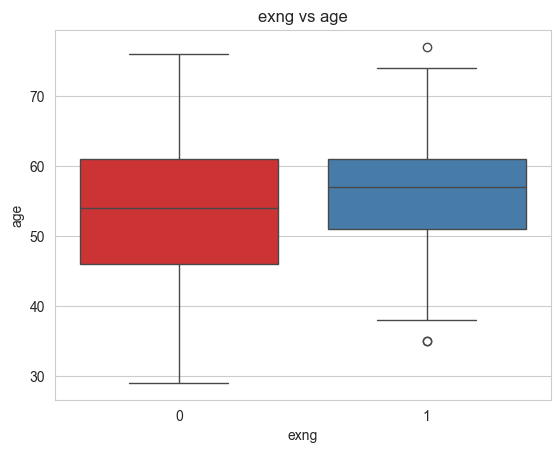

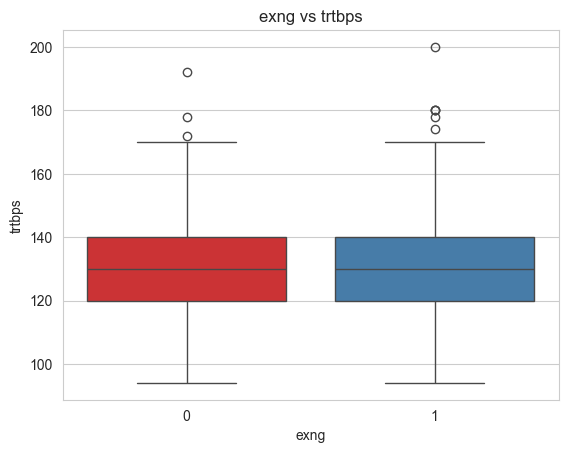

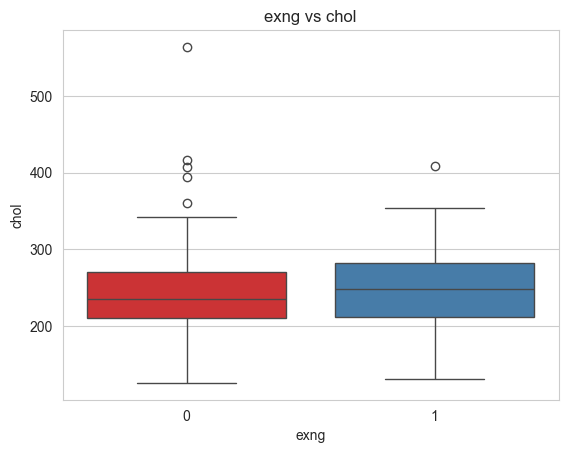

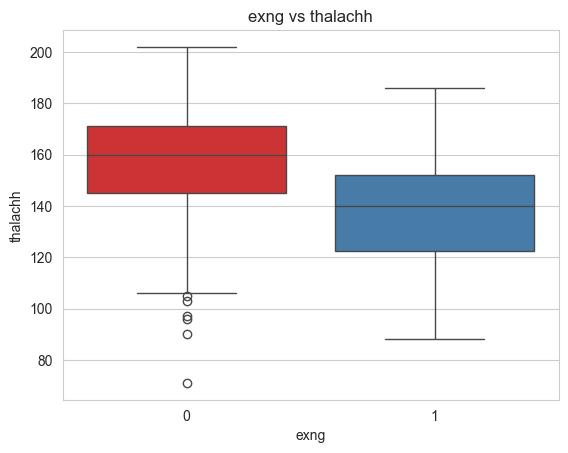

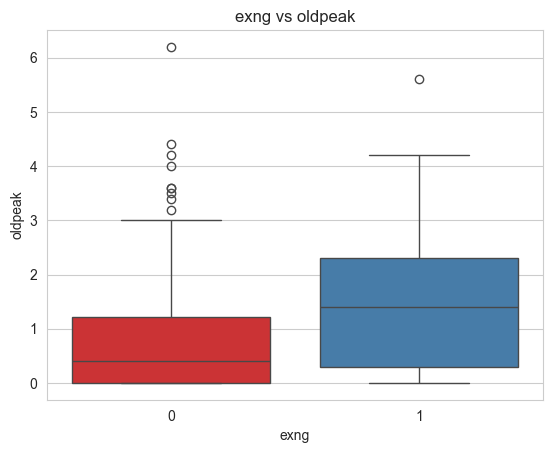

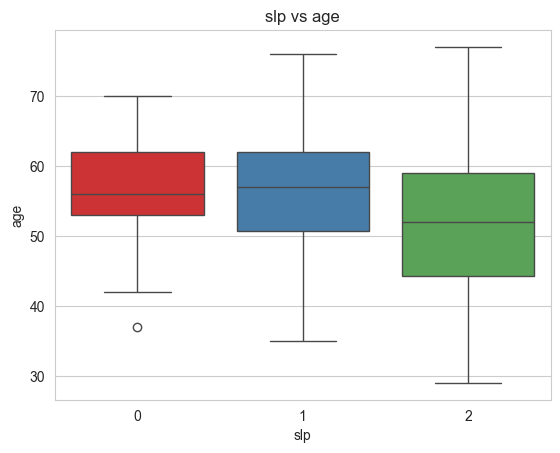

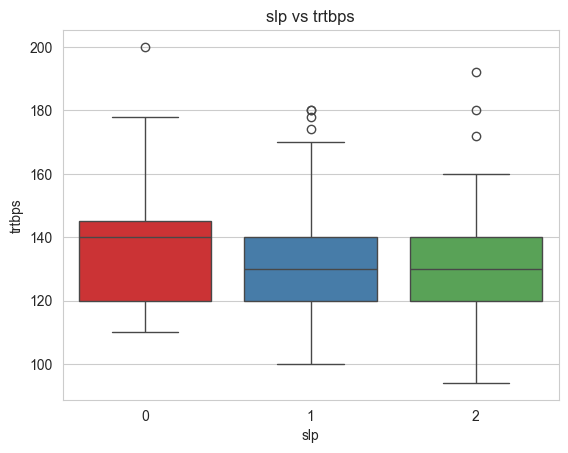

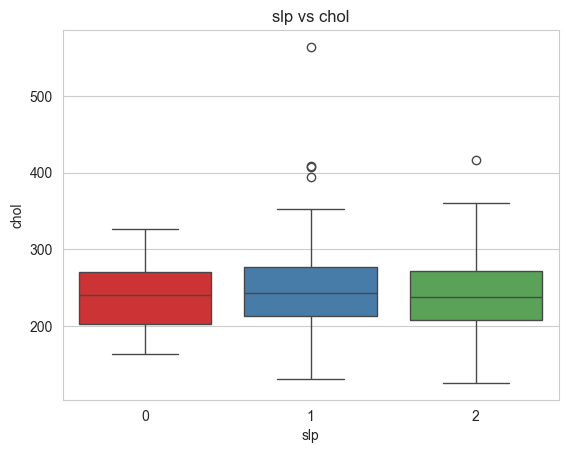

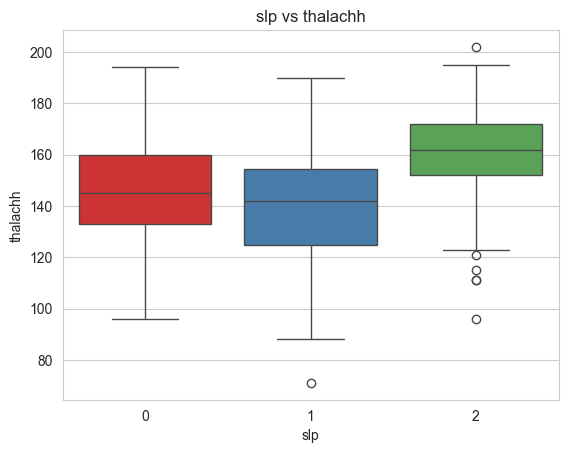

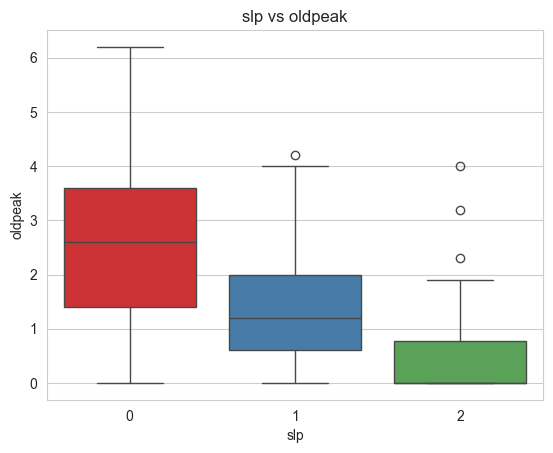

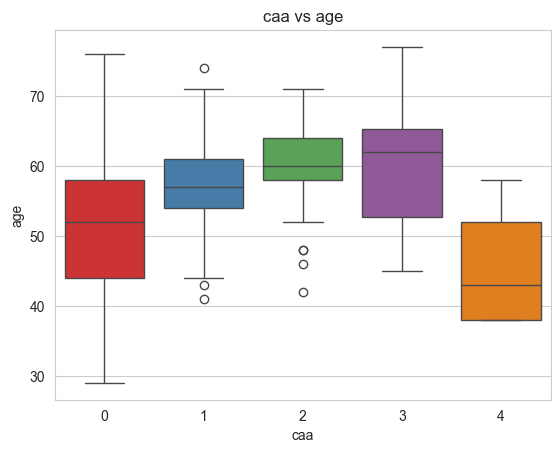

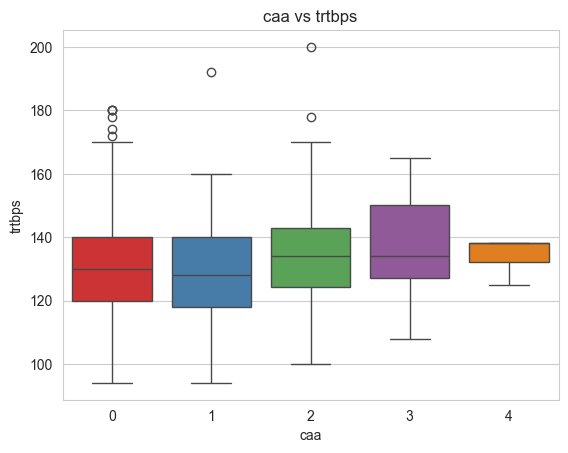

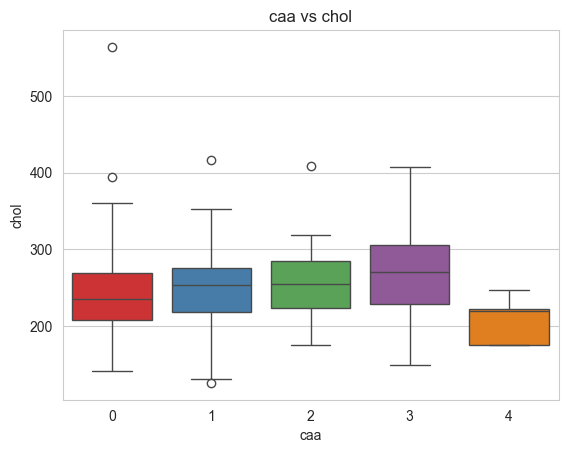

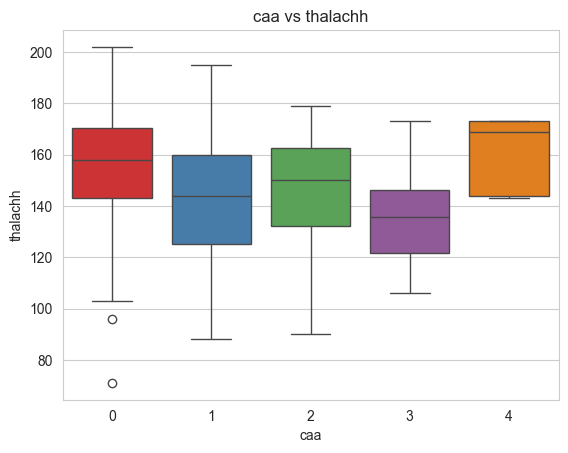

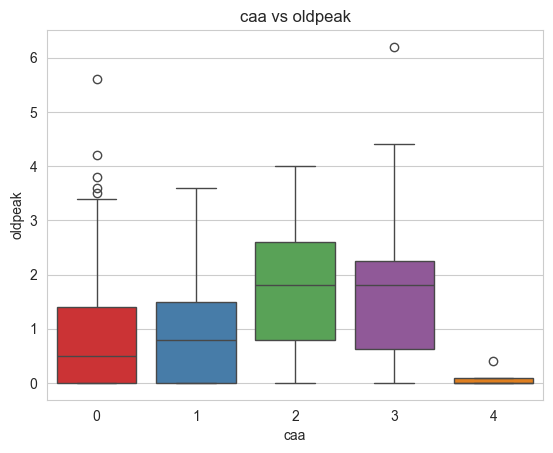

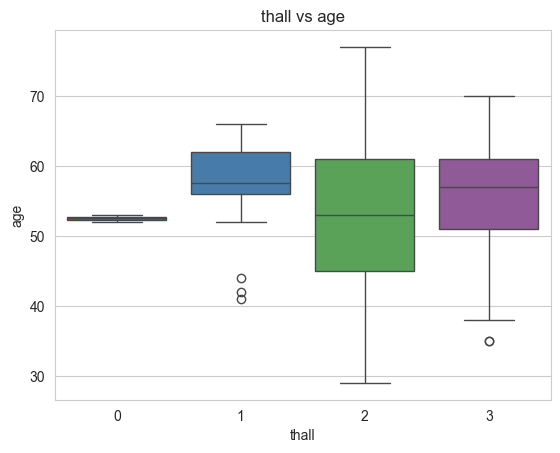

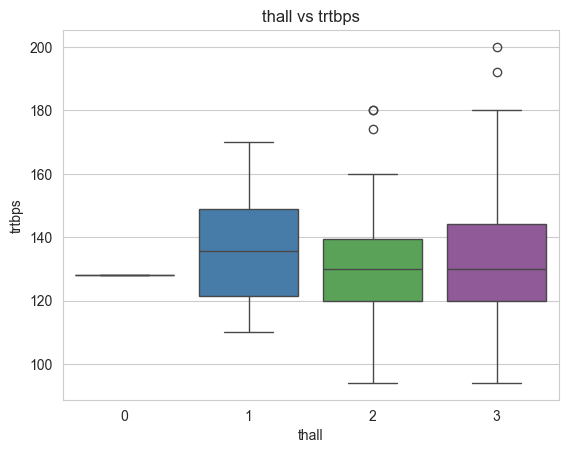

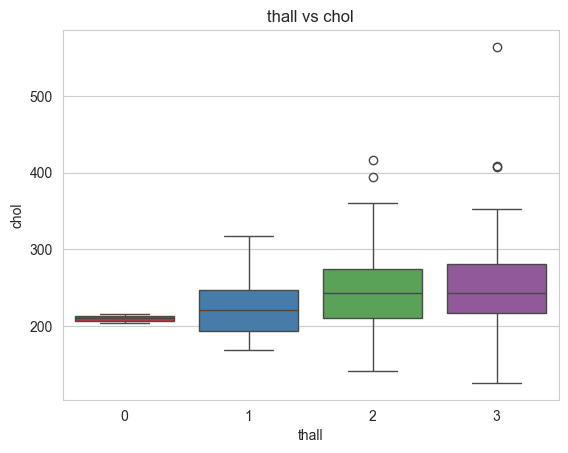

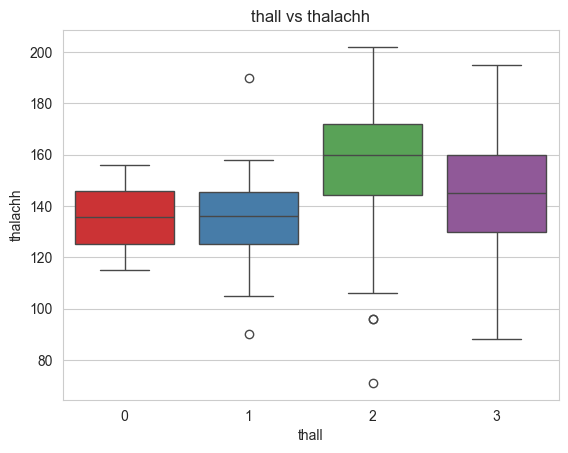

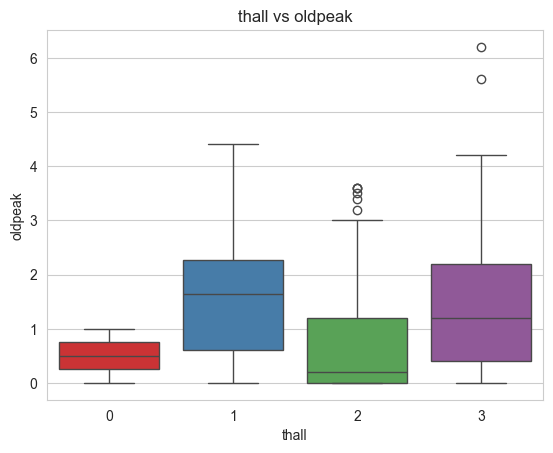

In [74]:
cat_num_pairs = list(product(cat_vars, num_vars))
for cat, num in cat_num_pairs:
    sns.boxplot(df, x=cat, y=num, palette="Set1")
    plt.title(f"{cat} vs {num}")
    plt.show()

### Categorical vs Categorical

## Multivariate Analysis